# Task 3 - Reinforcement Learning 
## Introduction and Aims
This final task explores reinforcement learning though OpenAI’s gym “MountainCar-v0” environment. Reinforcement learning is a branch of machine learning that uses an agent to navigate a simulated environment. The agent can take actions and hence learn which actions lead to the highest rewards.

<p >
    <img src="images/car.PNG" width="150" />
<p> 

## Theory 
In reinforcement learning the reward for an action can be delayed, as opposed to conventional supervised learning tasks where it is immediate. This means the agent can learn strategies to maximise the rewards in the long-term. There are different algorithms that can be used to define which action should be completed in a particular state. These include q-Learning, state–action–reward–state–action (SARSA), and the Monte Carlo algorithm [18]. In this task the q-learning algorithm is utilised.  

### Q-Learning 
Q-learning is a model-free version of reinforcement learning, using a q-table to determine which actions yields the highest reward in a certain state. The q-table possesses values for every possible action in every possible state. First, the q-table is randomly initialised. The values are then learned by updating the q-value after taking an action and receiving the reward [19]. The q-value is updated according to the following equation [20]: 
<p >
    <img src="images/q_formula.png" width="350" />
<p>  

### Exploration vs Exploitation trade-off
To learn, the agent has to first explore its environment, which is done by selecting a random action. The agent can then exploit this knowledge and act to maximise rewards. However, there is an “Exploration vs Exploitation trade-off” between the amount of time the agent spends exploring and exploiting [21]. Exploring for too long can lead to unnecessary bad results, whereas not exploring enough might get the agent stuck in patterns that are not optimal.

<br>

#### Epsilon-Greedy Policy and Decay Value 
The epsilon greedy algorithm is used to balance the exploration and exploitation trade-off. Epsilon represents the probability of choosing a random action. In the beginning, is it useful for epsilon to be high so that the environment is randomly explored. Later, having a smaller epsilon is better, as the environment has been explored and now should be exploited. Therefore, a decay value is introduced that decreases the epsilon after every episode [22]. 

The **learning rate (α)** determines how fast the agent learns [23]. An alpha of 0 means that the agent does not learn and hence acts randomly every time. A value of 1, on the other hand, means that the agent only remembers its most recent action. 

The **discount factor (γ)** indicates how important future rewards are compared with immediate rewards [23]. A discount factor of 0 only regards short-term rewards, whereas a discount factor of 1 values long-term rewards higher. In this case, the long-term rewards are more important than short-term rewards, as the car in this game only receives a reward when reaching the flag. 

## Exploratory Analysis 

In [15]:
import os
import gym
import numpy as np
import matplotlib.pyplot as plt

In [16]:
env = gym.make('MountainCar-v0')
print(env.observation_space.low)
print(env.observation_space.high)

[-1.2  -0.07]
[0.6  0.07]


The **first index** of the observation space indicates the **position** of the cart. From the statement above we know that the position can range from -1.2 to 0.6.  <br>

The **second index** of the observation space indicates the **velocity** of the cart. From the statement above we know that the position can range from -0.07 to 0.07.  <br>

In [17]:
print(env.reset())

[-0.5297567  0.       ]


This shows that the initial position of the cart is -0.5297567 and the initial velocity is 0 (standing).
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Model 

First, the **q-table** must be initialised in order to create the model. 

In [18]:
n = 5 # version of model 

# initialising the size of part of the discrete q table 
disc_obs_size = [40, 40]

# q-table: combining the chosen 'disc_obs_size' with 'number of actions'
q_table = np.random.uniform(low=-2, high=0, 
                            size=(disc_obs_size+[env.action_space.n]))

The states in this environment are continuous, containing up to 8 decimal places (see above). Therefore, they must be **discretized**. The following function is defined for this purpose:  

In [19]:
# size of discrete buckets 
disc_obs_bks = (env.observation_space.high-env.observation_space.low)/disc_obs_size
# continuous state to discrete state
def get_discrete_state(state):
    discrete_state = (state-env.observation_space.low)/disc_obs_bks
    return tuple(discrete_state.astype(int))

Next, the different hyperparameter (learning rate and discount), episodes and epsilon-greedy parameters must be defined. 

In [20]:
# hyperparamters
alpha = 0.1     # learning rate 
disc = 0.95     # discount 

episodes = 20000 # number of total episodes 

# epsilon-greedy parameters
epsilon = 1             
eps_decay_start = 1
eps_decay_end = episodes//2
epsilon_decay_value = epsilon/(eps_decay_end - eps_decay_start)

Now, the model can be built using a for-loop to loop through all episodes. The agent either acts randomly (this is more likely in the beginning when epsilon is higher) or it acts according to the q-table. Then the state, rewards, and q-table get updated. Furthermore, the epsilon decays after each episode. The average, maximum, and minimum of every episode are saved in a dictionary for later evaluation.

In [21]:
ep_rewards = []
# initilising dictionary to save the episode, its average, its max and its min
aggr_ep_rewards = {'ep': [], 'avg': [], 'max': [], 'min': []} 

for episode in range(episodes):
    episode_reward = 0                                # initial reward
    discrete_state = get_discrete_state(env.reset())  # initial discrete state
    done = False

    while not done:
        if np.random.random() > epsilon:                      # action from q-table
            action = np.argmax(q_table[discrete_state])
        else:                                                 # random action 
            action = np.random.randint(0, env.action_space.n)

        new_state, reward, done, _ = env.step(action)
        episode_reward = episode_reward + reward
        new_discrete_state = get_discrete_state(new_state)

        # updating q-table if not done 
        if not done:
            max_future_q = np.max(q_table[new_discrete_state]) # max q-val new state
            current_q = q_table[discrete_state + (action,)]    # current q-val
            new_q = (1-alpha)*current_q+alpha*(reward+disc*max_future_q)# new q-val
            q_table[discrete_state + (action,)] = new_q        # updating q-table 

        # updating q-value with reward directly if simulation has ended 
        elif new_state[0] >= env.goal_position:
            q_table[discrete_state + (action,)] = 0

        discrete_state = new_discrete_state      # updating discrete state

    # decaying epsilon within defined range  
    if eps_decay_end >= episode >= eps_decay_start:
        epsilon = epsilon- epsilon_decay_value
        
    ep_rewards.append(episode_reward)
        
    show_stats = 100  # saves stats every 100 episodes 
    if not (episode % show_stats or episode == 0):
        aggr_ep_rewards['ep'].append(episode)
        aggr_ep_rewards['avg'].append(sum(ep_rewards[-show_stats:])/show_stats)
        aggr_ep_rewards['max'].append(max(ep_rewards[-show_stats:]))
        aggr_ep_rewards['min'].append(min(ep_rewards[-show_stats:]))
env.close()

# save rewards for plotting against each other 
np.save(f"qtables/qtable{n}/rewards{n}.npy", aggr_ep_rewards)

### Plotting the min, max and average across every 100 episodes
Now that models with multiple hyperparameters have been explored and saved, they can be compared by looking at their plots. The hyperparameters of each model are shown below. 
#### Model versions: 
n = 1: disc_obs_size = [20, 20] + alpha = 0.5 + disc = 0.5 <br>
n = 2: disc_obs_size = [20, 20] + alpha = 0.5 + **disc = 0.95** <br>
n = 3: disc_obs_size = [20, 20] + **alpha = 0.1** + disc = 0.95<br>
n = 4: disc_obs_size = [20, 20] + alpha = 0.1 + disc = 0.95 + **eps_decay_end = episodes//3**<br>
n = 5: disc_obs_size = **[40, 40]** + alpha = 0.1 + disc = 0.95<br>

In [22]:
# loading all saved rewards  
for i in np.arange(1,6): 
    globals()['rewards%s' % i] = np.load(f"qtables/qtable{i}/rewards{i}.npy", 
                                         allow_pickle = True).item()

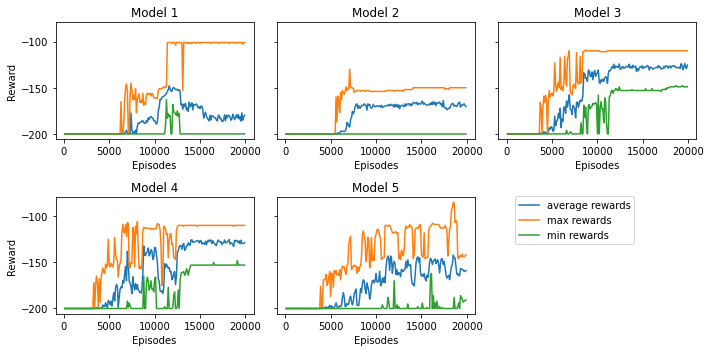

In [23]:
# list of all rewards to be plotted 
rewards = [rewards1, rewards2, rewards3, rewards4, rewards5]

fig, axes = plt.subplots(2,3, sharey = True, figsize = (10,5))
ax = axes.flatten()

# looping to create multiple plots
for i, reward in enumerate(rewards):
    ax[i].plot(reward['ep'], reward['avg'], label = "average rewards") 
    ax[i].plot(reward['ep'], reward['max'], label = "max rewards") 
    ax[i].plot(reward['ep'], reward['min'], label = "min rewards") 
    ax[i].set_title(f'Model {i+1}')
    ax[0].set_ylabel('Reward')
    ax[3].set_ylabel('Reward')
    ax[i].set_xlabel('Episodes')
    
for j in range(i+1, len(ax)): ax[j].axis('off') 
plt.tight_layout()
ax[1].legend(loc=(1.2, -0.9)) # only on legend for all plots

### Results and Hyperparameter Analysis 

In the first model, the discount rate and alpha are both 0.5. This means that the agent learns at a medium rate and rewards the medium-term rewards are important. The plot shows that the minimum reward is above -200 (at about -160) around episode 11000, meaning that even the worst agent always reaches its target. If it does not reach the target, the accumulated reward is -200. Simultaneously, the maximum is at about -100, which means that the best agent reaches its target using ca. 50 actions. 

In model 2 the discount factor is increased, as the car only gets a reward if it reaches the flag (so it must strive for the long-term reward). The maximum reward decreases, stabalising at -160, while the minimum reward is always zero. 
In model 3, alpha is decreased. This results in stable, high maximum (-110) and minimum rewards (-150). Decreasing the epsilon decay value, as done for model 4, does not change the results much. Plot 3 and 4 look very similar with model 4 stabalising slightly later. 

Increasing the size of the discrete observation space for the initial q-table, results in an almost linear trend for the maximum. In this model (5), the highest maximum reward is reached at ca  -82. However, the minimum reward for the same range of episodes is at about -190, which is not good compared to other models. 

### Reinforcement Learning in Smart Buildings
Reinforcement learning is increasingly being applied to building energy management problems to make buildings smarter and optimise energy usage and comfort [24]. There are many applications of RL in Smart Buildings, for example controller tuning, light management and heating and cooling management [25]. RL is especially promising for problems that cannot be efficiently solved by traditional models. For example, RL adapts better to diverse building environments as agents do not have to know the physical dwelling properties but learn by trial and error [26]. In physical model on the other hand, the parameters must be input. This adaptability makes RL better to scale up.  

In heating and cooling management, RL could optimise for thermal comfort while minimising the energy required [25]. For this, the rewards might be the negative energy input in kWh and negative predicted percentage of dissatisfied (PPD), which is the percentage of occupants that are either too cold or too hot. Another example is to use RL to manage consumption such that on-site generation, such as electricity from PV panels, is used as efficiently as possible. The agent might receive positive rewards when on-site renewables are used and negative rewards when grid electricity is used. The actions in this case would be to schedule appliance uses, such as running the washing machine. 

### Conclusion and Limitations
Deciding which model to pick, depends on its desired qualities. Model 5 reaches the highest max reward (-82) at 18000 episodes, with the downside of very low minimum rewards. Therefore, model 3 is chosen for this task, with alpha = 0.1 and the discount rate = 0.95. The best result is a reward of -110, while the minimum is still -150. The q-table of episodes around 12000 should be used.  

The exploration vs exploitation trade-off means that there is always the chance of exploring or exploiting more to get better results. This is an inherent limitation of q-learning. Furthermore, it is hard to reproduce results even when rerunning the analysis with the same hyperparameters, as q-learning depends on randomness. Another limitation of q-learning is that the states and actions must be discrete. This means that there is a limited amount of states and actions. The size of the q-table is also a limitation here, as the larger it is, the more memory it takes up, increasing the learning time. 